In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#srcdir = "/fs/lustre/cita/hadden/03_comet_diffusion/01_MEGNO_grid/megno_grids/"

# Check width calculation

In [3]:
from celmech.maps import CometMap

cmap = CometMap(5.15e-5,10,40/30,max_kmax=64)

cmap.q = 45/30

In [4]:
import sys
sys.path.append("../code/")
from sos_utils import get_map_pts

In [5]:
def calcH(theta,w,cmap,J,K):
    w0 = cmap.N - (J-K)/K
    dw = w-w0
    H=0.5*dw*dw
    for k_minus_one,amp in enumerate(cmap.amps):
        k=k_minus_one+1
        if k%K==0:
            ck = amp/k
            H+= (0.5/np.pi) * cmap.eps * ck * np.cos(k * theta) 
    return H

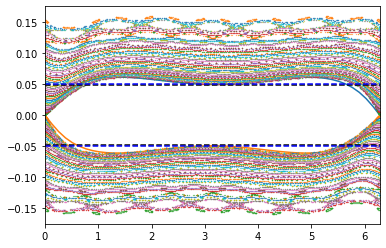

In [6]:
K = 1
J = K*cmap.N + 1
w0 = cmap.N - (J-K)/K
th_sx = 2*np.pi / K if K%2 else np.pi
wmin,wmax = w0 + 0.15 * np.array([-1,1])
theta,w = np.linspace(0,2*np.pi),np.linspace(wmin,wmax)
T,W = np.meshgrid(theta,w)

Energy = calcH(T,W,cmap,J,K)
Esx = calcH(th_sx,w0,cmap,J,K)

if K>1:
    CK = cmap.amps[K-1]/K
else:
    CK = cmap.amps[1]/2
Delta_w = 2 * np.sqrt(cmap.eps * CK / (2*np.pi))

# First order MMR
psq=0
Dw_at_pi=0
for k_minus_1 in range(cmap.kmax):
    k = k_minus_1 + 1
    C = cmap.amps[k_minus_1] / k
    A = (0.5/np.pi) * cmap.eps * C
    psq += 2 * (A - A * np.cos(k*theta))
    Dw_at_pi += 4 * A if k%2 else 0
wsx = w0+np.sqrt(psq)
Dw_at_pi = np.sqrt(Dw_at_pi)
plt.plot(theta,wsx)
plt.plot(theta,-wsx)

# Second order MMR
if False:
    psq=0
    Dw_at_pi=0
    for k_minus_1 in range(cmap.kmax):
        k = k_minus_1 + 1
        if k%2==0:
            C = cmap.amps[k_minus_1] / k
            A = (0.5/np.pi) * cmap.eps * C
            psq += 2 * (A - A * np.cos(k*theta))
    plt.plot(theta,-0.5+np.sqrt(psq))
    plt.plot(theta,0.5-np.sqrt(psq))



wrap1 = lambda x: np.mod(x+0.5,1)-0.5
for w in np.linspace(wmin,wmax,100):
    pts = get_map_pts((0,w),cmap,500)
    th,w = np.transpose(pts)
    w = wrap1(w)
    plt.plot(th,w,'.',ms=0.5)
# plt.contour(T,W,Energy,levels=[Esx],linewidths=[3],colors='red')

plt.xlim(0,2*np.pi)
plt.axhline(w0+Delta_w,ls='--',color='k')
plt.axhline(w0-Delta_w,ls='--',color='k')
plt.axhline(w0+Dw_at_pi,ls='--',color='b')
plt.axhline(w0-Dw_at_pi,ls='--',color='b')

# Make theory curve

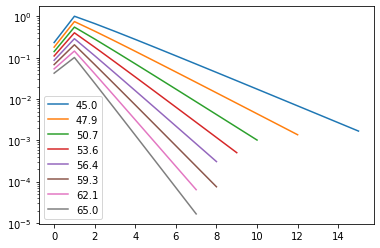

In [7]:
qvals = np.linspace(45,65,8)

eps_crits_2nd_order = np.zeros(len(qvals))
eps_crits = np.zeros(len(qvals))
eps_crits_tau2 = np.zeros(len(qvals))
reset = True
slopes,intercepts = np.zeros((2,len(qvals)))

for i,q in enumerate(qvals):
    cmap.q = q/30
    plt.plot(cmap.amps,label="{:.1f}".format(q))
    eps_crit = cmap.get_eps_crit()
    eps_crits[i] = eps_crit
    eps_crits_tau2[i] = cmap.get_eps_crit(tau=2)
    eps_crits_2nd_order[i] = cmap.get_eps_crit(kmax=2)
    kmax = cmap.kmax
    ks,amps = np.transpose([(km1+1,a/(km1+1)) for km1,a in enumerate(cmap.amps)])
    slopes[i],intercepts[i] = np.polyfit(ks[kmax//2:],np.log(amps[kmax//2:]),1)

plt.yscale('log')
plt.legend()

In [8]:
qvals_more = np.linspace(35,41,5,endpoint=True)

In [9]:
cmap.rtol = 0.05
cmap.atol = 1e-8

In [10]:
cmap.q = 38/30

/Users/shadden/Projects/celmech/celmech/maps.py:818: UserWarning: Failed to meet relative error tolerance 0.05 for k<64 
  warn("Failed to meet relative error tolerance {} for k<{} ".format(rtol,kmax))
/Users/shadden/Projects/celmech/celmech/maps.py:818: UserWarning: Failed to meet relative error tolerance 0.05 for k<64 
  warn("Failed to meet relative error tolerance {} for k<{} ".format(rtol,kmax))


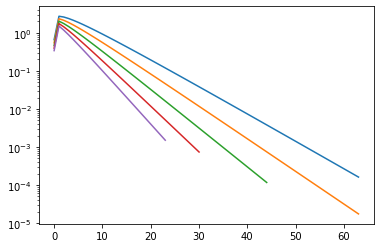

In [11]:
slopes_more,intercepts_more = np.zeros((2,len(qvals_more)))
eps_crits_2nd_order_more = np.zeros(len(qvals_more))
eps_crits_more = np.zeros(len(qvals_more))
eps_crits_more_tau2 = np.zeros(len(qvals_more))
for i,q in enumerate(qvals_more):
    cmap.q = q/30
    plt.plot(cmap.amps,label=q)
    eps_crit = cmap.get_eps_crit()
    eps_crits_more[i] = eps_crit
    eps_crits_more_tau2[i] = cmap.get_eps_crit(tau=2)
    eps_crits_2nd_order_more[i] = cmap.get_eps_crit(kmax=2)
    ks,amps = np.transpose([(km1+1,a/(km1+1)) for km1,a in enumerate(cmap.amps)])
    km = cmap.kmax
    slopes_more[i],intercepts_more[i] = np.polyfit(ks[km//2:],np.log(amps[km//2:]),1)
    

plt.yscale('log')

/Users/shadden/Projects/celmech/celmech/maps.py:831: UserWarning: Error increased before meeting relative error tolerance 0.05.Consider decreasing absolute accuracy parameter, atol=1e-08
  warn(msg)


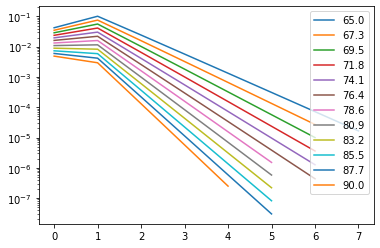

In [12]:
qvals_evenmore = np.linspace(65,3*30,12)
slopes_evenmore,intercepts_evenmore = np.zeros((2,len(qvals_evenmore)))
for i,q in enumerate(qvals_evenmore):
    cmap.q = q/30
    plt.plot(cmap.amps,label="{:.1f}".format(q))
    kmax = cmap.kmax
    ks,amps = np.transpose([(km1+1,a/(km1+1)) for km1,a in enumerate(cmap.amps)])
    slopes_evenmore[i],intercepts_evenmore[i] = np.polyfit(ks[kmax//2:],np.log(amps[kmax//2:]),1)
plt.legend()
plt.yscale('log')

In [13]:
qvals_all = np.concatenate((qvals_more,qvals))
eps_crits_all = np.concatenate((eps_crits_more,eps_crits))
eps_crits_all_tau2 = np.concatenate((eps_crits_more_tau2,eps_crits_tau2))
eps_crits_2nd_order_all = np.concatenate((eps_crits_2nd_order_more,eps_crits_2nd_order))

In [14]:
a_crit = (eps_crits_all / cmap.m / 3)**(2/5)
a_crit_tau2 = (eps_crits_all_tau2 / cmap.m / 3)**(2/5)
a_crit_so = (eps_crits_2nd_order_all / cmap.m / 3)**(2/5)

# Read simulation results

In [15]:
srcdir="../data/megno_data/megno_grids/" #"/fs/lustre/cita/hadden/03_comet_diffusion/01_MEGNO_grid/megno_grids/"
all_tLy = []
all_megno = []
all_eject = []
for I in range(9):
    fi = srcdir+"result{}.npy".format(I)
    data = np.load(fi)
    all_megno.append(data[:,:,0])
    all_tLy.append(1/data[:,:,1])
    all_eject.append(data[:,:,2])

tLy = np.block([all_tLy[:3],all_tLy[3:6],all_tLy[6:]])
megno = np.block([all_megno[:3],all_megno[3:6],all_megno[6:]])
eject = np.block([all_eject[:3],all_eject[3:6],all_eject[6:]])

tLy[megno<3] = 1e9
tLy[eject==1.] = 1e3
vals = np.log10(tLy)

/var/folders/0y/0wb96bc544s1wvz3qvx484qh0000gn/T/ipykernel_9628/3178047316.py:18: RuntimeWarning: invalid value encountered in log10
  vals = np.log10(tLy)


In [16]:
srcdir="../data/megno_data/megno_grids2/" #"/fs/lustre/cita/hadden/03_comet_diffusion/01_MEGNO_grid/megno_grids2/"

all_tLy_more = []
all_megno = []
all_eject = []
for I in range(9):
    fi = srcdir+"result{}.npy".format(I)
    data = np.load(fi)
    all_megno.append(data[:,:,0])
    all_tLy_more.append(1/data[:,:,1])
    all_eject.append(data[:,:,2])
    
srcdir="../data/megno_data/megno_grids3/" #"/fs/lustre/cita/hadden/03_comet_diffusion/01_MEGNO_grid/megno_grids3/"
all_tLy_3 = []
all_megno_3 = []
all_eject_3 = []
for I in range(3):
    fi = srcdir+"result{}.npy".format(I)
    data = np.load(fi)
    all_megno_3.append(data[:,:,0])
    all_tLy_3.append(1/data[:,:,1])
    all_eject_3.append(data[:,:,2])

tLy_more = np.hstack((
    np.block([all_tLy_more[:3],all_tLy_more[3:6],all_tLy_more[6:]]),
    np.vstack(all_tLy_3)
))
megno_more = np.hstack((
    np.block([all_megno[:3],all_megno[3:6],all_megno[6:]]),
    np.vstack(all_megno_3)
))
    
eject_more = np.hstack((
    np.block([all_eject[:3],all_eject[3:6],all_eject[6:]]),
    np.vstack(all_eject_3)
))
tLy_more[megno_more<3] = 1e9
tLy_more[eject_more==1.] = 1e3
vals_more = np.log10(tLy_more)

/var/folders/0y/0wb96bc544s1wvz3qvx484qh0000gn/T/ipykernel_9628/2175289331.py:39: RuntimeWarning: invalid value encountered in log10
  vals_more = np.log10(tLy_more)


In [17]:
def qcrit_batygin(a,aN = 30,mN = 5.15e-5):
    log_arg = 24*24 * mN *(a/aN)**(5/2) / 5
    return aN * np.sqrt(np.log(log_arg))

In [18]:
srcdir="../data/megno_data/megno_grids2/"#"/fs/lustre/cita/hadden/03_comet_diffusion/01_MEGNO_grid/megno_grids2/"
aranges = [np.load(srcdir + "a_range{}.npy".format(i)) for i in range(9)]
qranges = [np.load(srcdir + "q_range{}.npy".format(i)) for i in range(9)]

amin,amax=np.min(np.array(aranges)),np.max(np.array(aranges))
qmin,qmax=np.min(np.array(qranges)),np.max(np.array(qranges))

In [19]:
import pandas as pd

cols = "object,omega,Omega,inclination,e,q,a,M,n,Q,P,H"

cols = cols.split(",")

tnos_data = pd.read_csv("../data/mpc_tnos_big.tsv",sep="\t",names=cols)

tnos_data['cosi'] = np.cos(tnos_data.inclination * np.pi / 180)
tnos_data['Lz'] = np.sqrt((tnos_data.a * (1 - tnos_data.e * tnos_data.e))) * tnos_data.cosi
tnos_data['qmin'] = tnos_data.a - np.sqrt(tnos_data.a * (tnos_data.a - tnos_data.Lz**2))

/var/folders/0y/0wb96bc544s1wvz3qvx484qh0000gn/T/ipykernel_9628/291657099.py:3: RuntimeWarning: invalid value encountered in sqrt
  return aN * np.sqrt(np.log(log_arg))


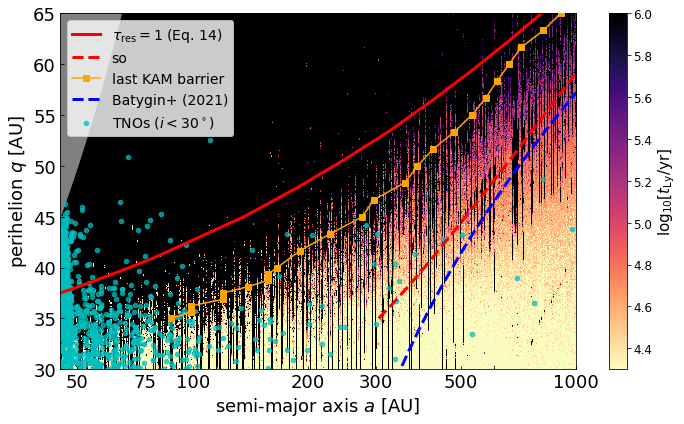

In [28]:
fig=plt.figure(figsize=(10,6))
plt.tick_params(direction='in',labelsize=18)
xticks = [50,75,100,200,300,500,1_000]
plt.xticks(np.log10(xticks),labels=["{}".format(x) for x in xticks])
ax = plt.gca()
im=plt.imshow(
    vals,
    interpolation="none",vmin=4.3,vmax=6,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(150),3,30,65]
)

im_more=plt.imshow(
    vals_more,
    interpolation="none",vmin=4.3,vmax=6,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(amin),np.log10(150),qmin,qmax]
)

cb = plt.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=12)
cb.set_label(r"$\log_{10}[t_\mathrm{Ly}/\mathrm{yr}]$",size=15)

plt.plot(np.log10(30*a_crit),qvals_all,color='r',lw=3,label=r"$\tau_\mathrm{res} = 1$ (Eq. 14)")
#plt.plot(np.log10(30*a_crit_tau2),qvals_all,ls='--',color='r',lw=3,label=r"$\tau_\mathrm{res} = 2$")
plt.plot(np.log10(30*a_crit_so),qvals_all,ls='--',color='r',lw=3,label=r"so")

q_lastKAM,KAMNmin = np.transpose(np.load("../data/last_kam_curves.npy"))
q_lastKAM2,KAMNmin2 = np.transpose(np.load("../data/last_kam_curves2.npy"))
q_lastKAM = np.concatenate((q_lastKAM,q_lastKAM2))
KAMNmin = np.concatenate((KAMNmin,KAMNmin2))
loga_lastKAM = np.log10(30 * KAMNmin**(2/3))
iorder = np.argsort(q_lastKAM)
plt.plot(loga_lastKAM[iorder],q_lastKAM[iorder],'s-',color='orange',zorder=99,label="last KAM barrier")




a = np.geomspace(150,1e3)
plt.plot(np.log10(a),qcrit_batygin(a),color='b',lw=3,ls='--',label=r"Batygin+ (2021)")
plt.xlim(np.log10(amin),np.log10(1e3))
plt.ylim(30,65)

# q,max_x = np.transpose(np.load("../data/max_x-vs-q.npy"))
# plt.plot(np.log10(30/max_x),q,'gs-',zorder=99)

im_blank=plt.imshow(
    [[1,1],[1,1]],
    interpolation="none",vmin=0,vmax=1,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(amin),np.log10(150),45,65]
)
plt.fill_between(np.log10(np.linspace(45,65)),np.linspace(45,65),65,color='gray')


#plt.scatter(np.log10(tnos_data.a),tnos_data.q,color='b',s=20,alpha=0.5)
plt.scatter(np.log10(tnos_data.a),tnos_data.qmin,color='c',s=20,alpha=0.75,label=r"TNOs $(i<30^\circ)$")


plt.legend(loc='upper left',fontsize=14)
plt.xlabel("semi-major axis $a$ [AU]",fontsize=18)
plt.ylabel("perihelion $q$ [AU]",fontsize=18)
plt.tight_layout()

#plt.savefig("/Users/shadden/DropboxPersonal/Apps/Overleaf/CometMap/figures/MEGNO_map.png")



In [63]:
X = np.linspace(36,75,25)
widths_fo = np.zeros(len(X))
widths_so = np.zeros(len(X))
for i,q in enumerate(X):
    cmap.q = q/30
    F0 = cmap.F(0)
    Fpi = cmap.F(np.pi)
    widths_fo[i] = 4 * cmap.a0**(-0.25) * np.sqrt(cmap.m/3/np.pi) *np.sqrt(F0-Fpi)
    c2 = cmap.ck[1]
    widths_so[i] = 4 * cmap.a0**(-0.25) * np.sqrt(2*cmap.m/3/np.pi) * np.sqrt(c2)

/Users/shadden/Projects/celmech/celmech/maps.py:818: UserWarning: Failed to meet relative error tolerance 0.05 for k<64 
  warn("Failed to meet relative error tolerance {} for k<{} ".format(rtol,kmax))


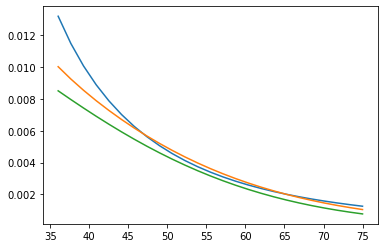

In [64]:
da_batygin = 8 * cmap.a0**(-0.25) * np.sqrt(cmap.m/5) * np.exp( - 0.5 * (X/30)**2 )
plt.plot(X,widths_fo)
plt.plot(X,widths_so)
plt.plot(X,da_batygin)


In [72]:
X[widths_fo/da_batygin-1>0.2]

array([36.   , 37.625, 39.25 , 40.875, 42.5  , 65.25 , 66.875, 68.5  ,
       70.125, 71.75 , 73.375, 75.   ])

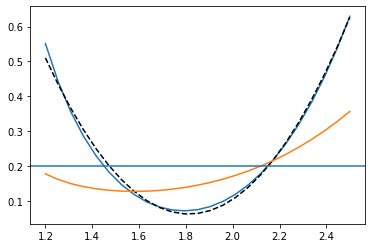

In [74]:
plt.plot(X/30,widths_fo/da_batygin-1)

a,b,c = np.polyfit(X,widths_fo/da_batygin-1,2)
plt.plot(X/30,a*X*X + b*X + c,'k--')

plt.plot(X/30,widths_so/da_batygin-1)
plt.axhline(0.2)

In [71]:
a,b,c

(0.0013242118597836825, -0.14401292808725488, 3.9785823832344973)

/var/folders/0y/0wb96bc544s1wvz3qvx484qh0000gn/T/ipykernel_9628/291657099.py:3: RuntimeWarning: invalid value encountered in sqrt
  return aN * np.sqrt(np.log(log_arg))


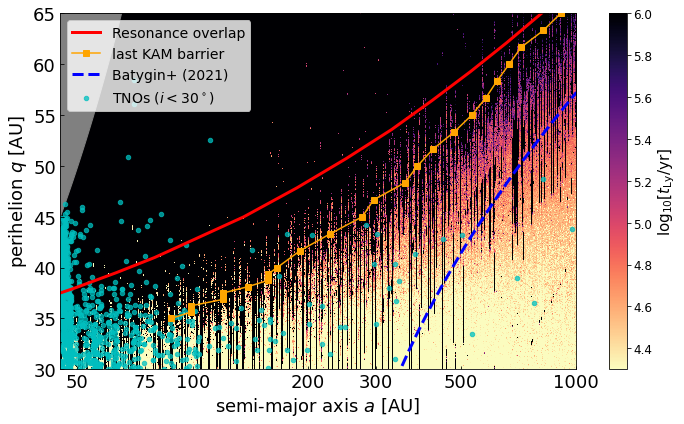

In [21]:
fig=plt.figure(figsize=(10,6))
plt.tick_params(direction='in',labelsize=18)
xticks = [50,75,100,200,300,500,1_000]
plt.xticks(np.log10(xticks),labels=["{}".format(x) for x in xticks])
ax = plt.gca()
im=plt.imshow(
    vals,
    interpolation="none",vmin=4.3,vmax=6,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(150),3,30,65]
)

im_more=plt.imshow(
    vals_more,
    interpolation="none",vmin=4.3,vmax=6,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(amin),np.log10(150),qmin,qmax]
)

cb = plt.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=12)
cb.set_label(r"$\log_{10}[t_\mathrm{Ly}/\mathrm{yr}]$",size=15)

plt.plot(np.log10(30*a_crit),qvals_all,color='r',lw=3,label=r"Resonance overlap")

q_lastKAM,KAMNmin = np.transpose(np.load("../data/last_kam_curves.npy"))
q_lastKAM2,KAMNmin2 = np.transpose(np.load("../data/last_kam_curves2.npy"))
q_lastKAM = np.concatenate((q_lastKAM,q_lastKAM2))
KAMNmin = np.concatenate((KAMNmin,KAMNmin2))
loga_lastKAM = np.log10(30 * KAMNmin**(2/3))
iorder = np.argsort(q_lastKAM)
plt.plot(loga_lastKAM[iorder],q_lastKAM[iorder],'s-',color='orange',zorder=99,label="last KAM barrier")




a = np.geomspace(150,1e3)
plt.plot(np.log10(a),qcrit_batygin(a),color='b',lw=3,ls='--',label=r"Batygin+ (2021)")
plt.xlim(np.log10(amin),np.log10(1e3))
plt.ylim(30,65)

# q,max_x = np.transpose(np.load("../data/max_x-vs-q.npy"))
# plt.plot(np.log10(30/max_x),q,'gs-',zorder=99)

im_blank=plt.imshow(
    [[1,1],[1,1]],
    interpolation="none",vmin=0,vmax=1,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(amin),np.log10(150),45,65]
)
plt.fill_between(np.log10(np.linspace(45,65)),np.linspace(45,65),65,color='gray')


#plt.scatter(np.log10(tnos_data.a),tnos_data.q,color='b',s=20,alpha=0.5)
plt.scatter(np.log10(tnos_data.a),tnos_data.qmin,color='c',s=20,alpha=0.75,label=r"TNOs $(i<30^\circ)$")


plt.legend(loc='upper left',fontsize=14)
plt.xlabel("semi-major axis $a$ [AU]",fontsize=18)
plt.ylabel("perihelion $q$ [AU]",fontsize=18)
plt.tight_layout()

#plt.savefig("/Users/shadden/Presentations/2023_05_Lansing_MI_DDA/figures/MEGNO_map_simple.png")



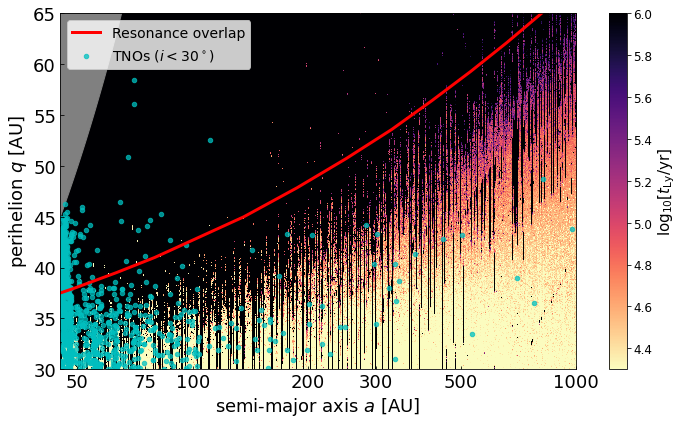

In [22]:
fig=plt.figure(figsize=(10,6))
plt.tick_params(direction='in',labelsize=18)
xticks = [50,75,100,200,300,500,1_000]
plt.xticks(np.log10(xticks),labels=["{}".format(x) for x in xticks])
ax = plt.gca()
im=plt.imshow(
    vals,
    interpolation="none",vmin=4.3,vmax=6,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(150),3,30,65]
)

im_more=plt.imshow(
    vals_more,
    interpolation="none",vmin=4.3,vmax=6,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(amin),np.log10(150),qmin,qmax]
)

cb = plt.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=12)
cb.set_label(r"$\log_{10}[t_\mathrm{Ly}/\mathrm{yr}]$",size=15)

plt.plot(np.log10(30*a_crit),qvals_all,color='r',lw=3,label=r"Resonance overlap")

q_lastKAM,KAMNmin = np.transpose(np.load("../data/last_kam_curves.npy"))
q_lastKAM2,KAMNmin2 = np.transpose(np.load("../data/last_kam_curves2.npy"))
q_lastKAM = np.concatenate((q_lastKAM,q_lastKAM2))
KAMNmin = np.concatenate((KAMNmin,KAMNmin2))
loga_lastKAM = np.log10(30 * KAMNmin**(2/3))
iorder = np.argsort(q_lastKAM)
#plt.plot(loga_lastKAM[iorder],q_lastKAM[iorder],'s-',color='orange',zorder=99,label="last KAM barrier")




a = np.geomspace(150,1e3)
#plt.plot(np.log10(a),qcrit_batygin(a),color='b',lw=3,ls='--',label=r"Batygin+ (2021)")
plt.xlim(np.log10(amin),np.log10(1e3))
plt.ylim(30,65)

# q,max_x = np.transpose(np.load("../data/max_x-vs-q.npy"))
# plt.plot(np.log10(30/max_x),q,'gs-',zorder=99)

im_blank=plt.imshow(
    [[1,1],[1,1]],
    interpolation="none",vmin=0,vmax=1,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(amin),np.log10(150),45,65]
)
plt.fill_between(np.log10(np.linspace(45,65)),np.linspace(45,65),65,color='gray')


#plt.scatter(np.log10(tnos_data.a),tnos_data.q,color='b',s=20,alpha=0.5)
plt.scatter(np.log10(tnos_data.a),tnos_data.qmin,color='c',s=20,alpha=0.75,label=r"TNOs $(i<30^\circ)$")


plt.legend(loc='upper left',fontsize=14)
plt.xlabel("semi-major axis $a$ [AU]",fontsize=18)
plt.ylabel("perihelion $q$ [AU]",fontsize=18)
plt.tight_layout()

#plt.savefig("/Users/shadden/Presentations/2023_05_Lansing_MI_DDA/figures/MEGNO_map_simpler.png")



In [23]:
from sympy.ntheory import totient
def epscrit_alt(cmap):
    F0 = cmap.F(0)
    Fpi = cmap.F(np.pi)
    tot = 2 * np.sqrt((F0 - Fpi)/np.pi)
    for km1,ck in enumerate(cmap.ck):
        k = km1 + 1
        if k>1:
            tot += 2 * totient(k) * np.sqrt(2 * ck/np.pi)
    
    return 1/tot/tot

In [24]:
new_qs = np.linspace(38,65)
new_eps = np.zeros(len(new_qs))
for i,q in enumerate(new_qs):
    cmap.q = q/30
    new_eps[i] = epscrit_alt(cmap)

In [25]:
new_acrit = 30 * (new_eps/cmap.m/3)**(2/5)

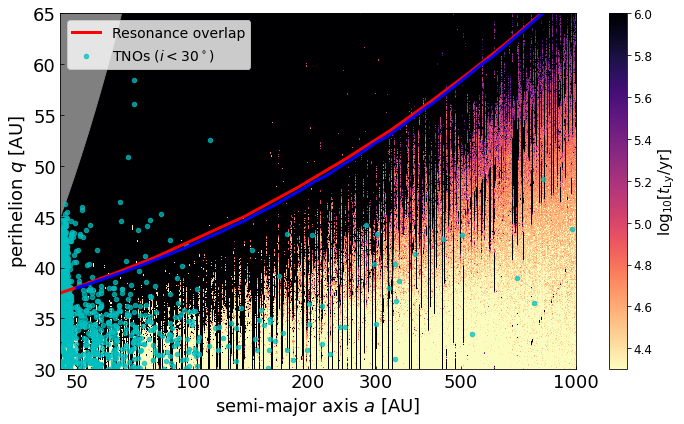

In [26]:
fig=plt.figure(figsize=(10,6))
plt.tick_params(direction='in',labelsize=18)
xticks = [50,75,100,200,300,500,1_000]
plt.xticks(np.log10(xticks),labels=["{}".format(x) for x in xticks])
ax = plt.gca()
im=plt.imshow(
    vals,
    interpolation="none",vmin=4.3,vmax=6,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(150),3,30,65]
)

im_more=plt.imshow(
    vals_more,
    interpolation="none",vmin=4.3,vmax=6,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(amin),np.log10(150),qmin,qmax]
)

cb = plt.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=12)
cb.set_label(r"$\log_{10}[t_\mathrm{Ly}/\mathrm{yr}]$",size=15)

plt.plot(np.log10(30*a_crit),qvals_all,color='r',lw=3,label=r"Resonance overlap")

q_lastKAM,KAMNmin = np.transpose(np.load("../data/last_kam_curves.npy"))
q_lastKAM2,KAMNmin2 = np.transpose(np.load("../data/last_kam_curves2.npy"))
q_lastKAM = np.concatenate((q_lastKAM,q_lastKAM2))
KAMNmin = np.concatenate((KAMNmin,KAMNmin2))
loga_lastKAM = np.log10(30 * KAMNmin**(2/3))
iorder = np.argsort(q_lastKAM)
#plt.plot(loga_lastKAM[iorder],q_lastKAM[iorder],'s-',color='orange',zorder=99,label="last KAM barrier")




a = np.geomspace(150,1e3)
#plt.plot(np.log10(a),qcrit_batygin(a),color='b',lw=3,ls='--',label=r"Batygin+ (2021)")
plt.xlim(np.log10(amin),np.log10(1e3))
plt.ylim(30,65)

# q,max_x = np.transpose(np.load("../data/max_x-vs-q.npy"))
# plt.plot(np.log10(30/max_x),q,'gs-',zorder=99)

im_blank=plt.imshow(
    [[1,1],[1,1]],
    interpolation="none",vmin=0,vmax=1,
    cmap="magma_r",origin="lower",aspect="auto",
    extent=[np.log10(amin),np.log10(150),45,65]
)
plt.fill_between(np.log10(np.linspace(45,65)),np.linspace(45,65),65,color='gray')


#plt.scatter(np.log10(tnos_data.a),tnos_data.q,color='b',s=20,alpha=0.5)
plt.scatter(np.log10(tnos_data.a),tnos_data.qmin,color='c',s=20,alpha=0.75,label=r"TNOs $(i<30^\circ)$")

plt.plot(np.log10(new_acrit),new_qs,'b',lw=3)

plt.legend(loc='upper left',fontsize=14)
plt.xlabel("semi-major axis $a$ [AU]",fontsize=18)
plt.ylabel("perihelion $q$ [AU]",fontsize=18)
plt.tight_layout()

#plt.savefig("/Users/shadden/Presentations/2023_05_Lansing_MI_DDA/figures/MEGNO_map_simpler.png")




In [27]:
totient(3)

2

In [ ]:
cmap.m = 5e-6
cmap.q = 9/8+0.15
p0 = (0,0.5+1e-5)

In [95]:
30 * 9 / 8

33.75

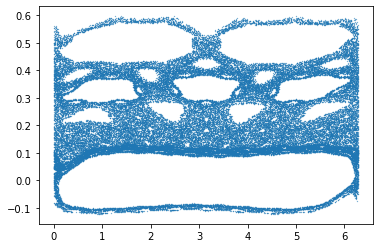

In [100]:
cmap.N = 45
cmap.mod=False
orbit =get_map_pts(p0,cmap,60_000)

theta,w = np.transpose(orbit)

plt.plot(np.mod(theta,2*np.pi),w,'.',ms=0.5)

In [110]:
import rebound as rb
from celmech.nbody_simulation_utilities import set_time_step
from celmech.nbody_simulation_utilities import get_simarchive_integration_results

In [154]:
a**(1.5)

65.97807947932345

In [163]:
sim = rb.Simulation()
sim.add(m=1)
sim.add(m=5e-5,a = 1)
q = 9/8
for dP in np.linspace(-0.01,0.01,100):
    Pratio = 10.5 + dP
    a = Pratio**(2/3) 
    e = 1-q/a
    sim.add(m=0,P = Pratio * 2* np.pi,e = e, pomega = 0 , M = 0 )
sim.move_to_com()
sim.integrator='whfast'

sim.ri_whfast.safe_mode = 0

set_time_step(sim,1/20)
sim.automateSimulationArchive('tps.sa',interval=100 * sim.particles[1].P,deletefile=True)


sim.integrate(5e5 * sim.particles[1].P)

In [ ]:
results=get_simarchive_integration_results("tps.sa")
results['q'] = results['a'] * (1 - results['e'])

/Users/shadden/anaconda/envs/celmech/lib/python3.9/site-packages/rebound/simulation.py:1987: FutureWarning: sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead
  warnings.warn( "sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead", FutureWarning)


(0.5, 3.0)

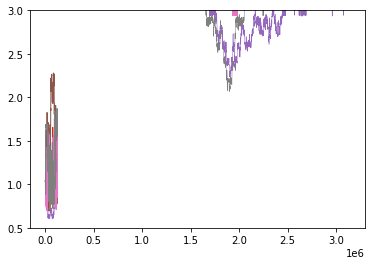

In [192]:
for i in range(1,99):
    l,=plt.plot(results['time'],results['P'][i]/(2*np.pi),lw=0.5)
plt.ylim(1,5)

results2 = get_simarchive_integration_results('tps2.sa')
for i in range(1,sim.N-1):
    l,=plt.plot(results2['time'],results2['P'][i]/(2*np.pi),lw=1)
plt.ylim(0.5,3)

In [189]:
sim = rb.Simulation()
sim.add(m=1)
sim.add(m=5e-5,a = 1)
p1 = sim.particles[1]
for da in np.linspace(-0.1,0.1,10):
    sim.add(m=0,a = 1 + (1 + da)* p1.rhill,l=np.pi)
sim.integrator='mercurius'
sim.ri_mercurius.hillfac = 5
sim.move_to_com()
set_time_step(sim,1/20)
sim.automateSimulationArchive('tps2.sa',interval=100 * sim.particles[1].P,deletefile=True)
sim.integrate(2e4 * sim.particles[1].P)

/Users/shadden/anaconda/envs/celmech/lib/python3.9/site-packages/rebound/simulation.py:1987: FutureWarning: sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead
  warnings.warn( "sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead", FutureWarning)


(0.5, 3.0)

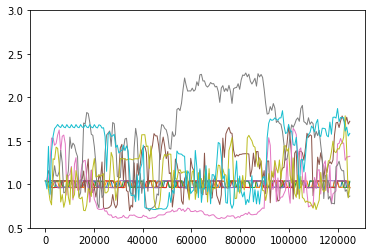

In [191]:
results2 = get_simarchive_integration_results('tps2.sa')
for i in range(1,sim.N-1):
    l,=plt.plot(results2['time'],results2['P'][i]/(2*np.pi),lw=1)
plt.ylim(0.5,3)

In [213]:
newsim = rb.Simulation()
newsim.add(sim.particles[0].copy())
newsim.add(sim.particles[1].copy())
newsim.add(sim.particles[9].copy())
newsim.t = sim.t

In [214]:
newsim.integrator='mercurius'
newsim.ri_mercurius.hillfac = 5
newsim.move_to_com()
set_time_step(newsim,1/20)

In [225]:
newsim.automateSimulationArchive('runme.sa',interval=100 * newsim.particles[1].P,deletefile=False)
newsim.integrate(newsim.t + 3e5 * newsim.particles[1].P)

/Users/shadden/anaconda/envs/celmech/lib/python3.9/site-packages/rebound/simulation.py:1032: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


/Users/shadden/anaconda/envs/celmech/lib/python3.9/site-packages/rebound/simulation.py:1987: FutureWarning: sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead
  warnings.warn( "sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead", FutureWarning)


8


/Users/shadden/anaconda/envs/celmech/lib/python3.9/site-packages/rebound/simulation.py:1987: FutureWarning: sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead
  warnings.warn( "sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead", FutureWarning)


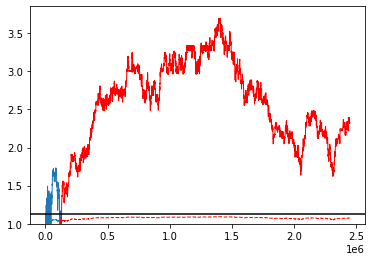

In [227]:
results2 = get_simarchive_integration_results('tps2.sa')
for i in range(1,sim.N-1):
    
    if np.any(results2['P'][i]/(2*np.pi)>2):
        print(i)
        l,=plt.plot(results2['time'],results2['a'][i],lw=1)
        l,=plt.plot(results2['time'],results2['a'][i] * (1 -results2['e'][i] ),lw=1,color=l.get_color(),ls='--')
results3 = get_simarchive_integration_results('runme.sa')

l,=plt.plot(results3['time'],results3['a'][1],color='r',lw=1)
l,=plt.plot(results3['time'],results3['a'][1] * (1 -results3['e'][1] ),lw=1,color='r',ls='--')

plt.ylim(ymin=1)
plt.axhline(9/8,color='k')

In [219]:
l,=plt.plot(results3['time'],results3['a'][1] * (1 -results3['e'][i] ),lw=1,color='r',ls='--')

IndexError: index 10 is out of bounds for axis 0 with size 2